In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.io as sio
from pandas import Series
from scipy import signal
import scipy.fftpack


---
# VIDEO: Total and windowed variance and RMS
---

Variance in  signal is also the measure of energie.
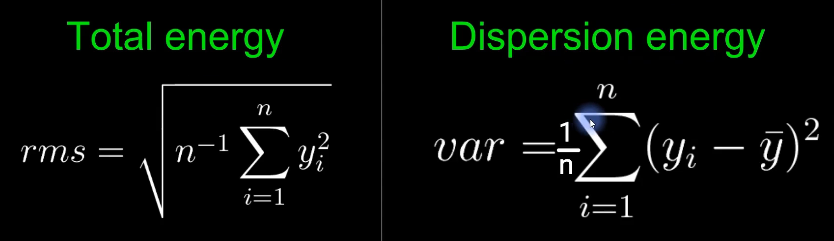

In the example below the variance capture the localized fluctuations.

Rms is robust to the fluctuations and capture the general trend.

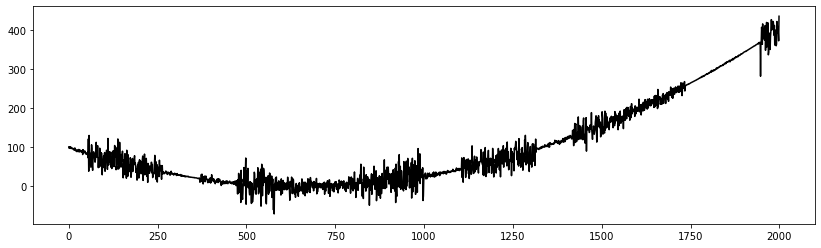

In [4]:
# generate signal with varying variability
n = 2000
p = 20 # poles for random interpolation

# amplitude modulator
ampmod = griddata(np.arange(0,p), np.random.rand(p)*30, np.linspace(0,p-1,n), method='nearest')
ampmod = ampmod + np.mean(ampmod)/3*np.sin(np.linspace(0,6*np.pi,n))

# signal and modulated noise plus quadratic
signal1 = ampmod * np.random.randn(n)
signal1 = signal1 + np.linspace(-10,20,n)**2

plt.figure(figsize=(14,4))
# plot the signal
plt.plot(signal1,'k')
plt.show()

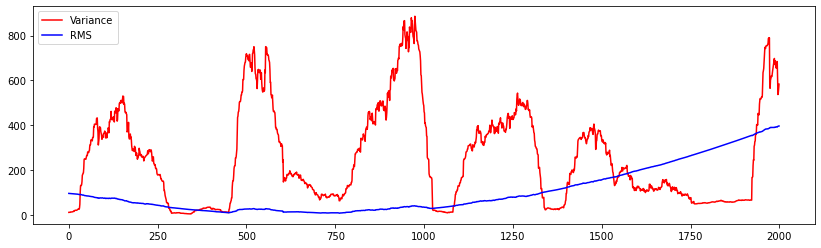

In [5]:
## compute windowed variance and RMS

# window size (NOTE: actual window is halfwin*2+1)
halfwin = 25 # in points

var_ts = np.zeros(n)
rms_ts = np.zeros(n)

for ti in range(0,n):
    
    # boundary points
    low_bnd = np.max((0,ti-halfwin))
    upp_bnd = np.min((n,ti+halfwin))
    
    # signal segment
    tmpsig = signal1[range(low_bnd,upp_bnd)]
    
    # compute variance and RMS in this window
    var_ts[ti] = np.var(tmpsig)
    rms_ts[ti] = np.sqrt(np.mean( tmpsig**2 ))

plt.figure(figsize=(14,4))
# and plot
plt.plot(var_ts,'r',label='Variance')
plt.plot(rms_ts,'b',label='RMS')
plt.legend()
plt.show()


---
# VIDEO: Signal-to-noise ratio (SNR)
---

SNR is just signal/noise

But there is different ways to compute noise.

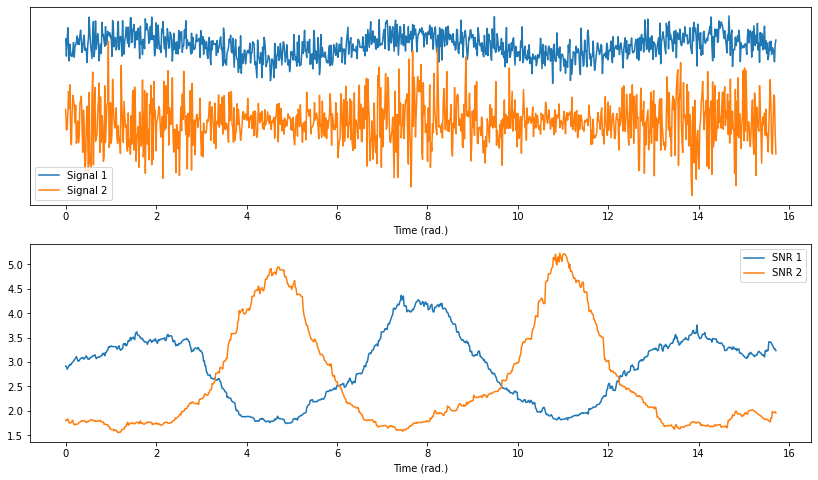

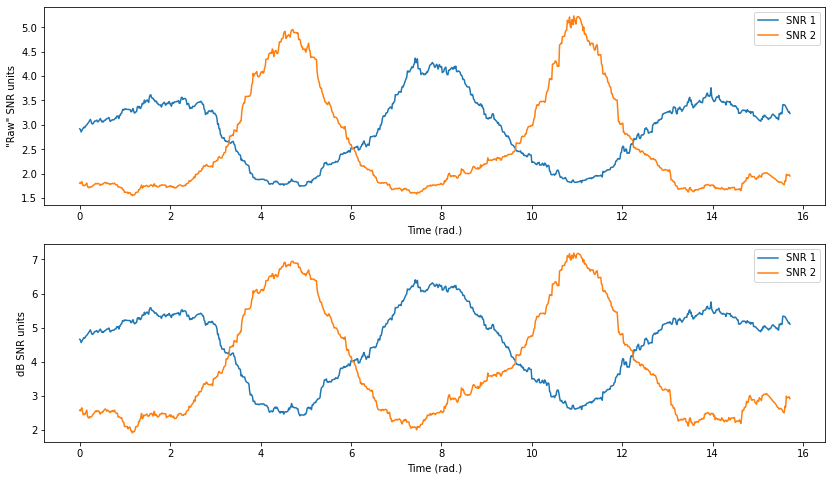

In [2]:

# simulation params
pnts = 1000
time = np.linspace(0,5*np.pi,pnts)

# one signal plus noise (the signal varying in intensity but the noise is constant)
signal1 = 3+np.sin(time)
signal1 = signal1 + np.random.randn(pnts)

# another signal (the signal is flat but the noise is varying in intensities)
signal2 = 5 + np.random.randn(pnts) * (2+np.sin(time))



# compute SNR in sliding windows
k = int(pnts*.05)  # one-sided window is 5% of signal length

# initialize
snr_ts1 = np.zeros(pnts)
snr_ts2 = np.zeros(pnts)


# loop over time points
for i in range(0,pnts):
    
    # time boundaries
    bndL = max((0,i-k))
    bndU = min((pnts,i+k))
    
    # extract parts of signals
    sigpart1 = signal1[range(bndL,bndU)]
    sigpart2 = signal2[range(bndL,bndU)]
    
    # compute windowed SNR
    snr_ts1[i] = np.mean(sigpart1) / np.std(sigpart1)
    snr_ts2[i] = np.mean(sigpart2) / np.std(sigpart2)
    

plt.figure(figsize=(14,8))
# plot the signals
plt.subplot(211)
plt.plot(time,signal1+10,label='Signal 1')
plt.plot(time,signal2,label='Signal 2')
plt.yticks([],[])
plt.xlabel('Time (rad.)')
plt.legend()

# plot SNRs
plt.subplot(212)
plt.plot(time,snr_ts1,label='SNR 1')
plt.plot(time,snr_ts2,label='SNR 2')
plt.legend()
plt.xlabel('Time (rad.)')
plt.show()


plt.figure(figsize=(14,8))
# plot SNRs
plt.subplot(211)
plt.plot(time,snr_ts1,label='SNR 1')
plt.plot(time,snr_ts2,label='SNR 2')
plt.legend()
plt.ylabel('"Raw" SNR units')
plt.xlabel('Time (rad.)')


plt.subplot(212)
plt.plot(time,10*np.log10(snr_ts1),label='SNR 1')
plt.plot(time,10*np.log10(snr_ts2),label='SNR 2')
plt.legend()
plt.ylabel('dB SNR units')
plt.xlabel('Time (rad.)')
plt.show()

In blue signal the SNR is increasing with higher signal

In orange signal the SNR is decreasing when the noise increase.

(2, 1281, 500)


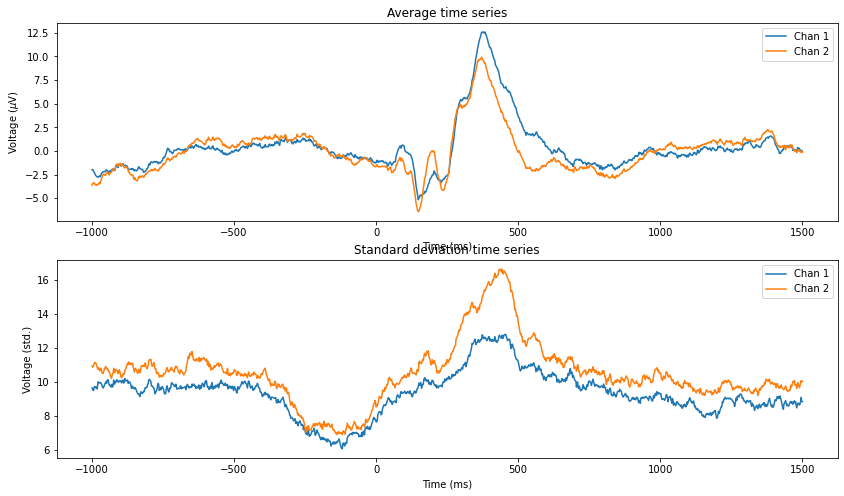

C:\Users\fabrice.lacout\AppData\Local\Temp\ipykernel_21488\1898667683.py:36: RuntimeWarning: invalid value encountered in log10
  plt.plot(timevec,10*np.log10(snr).T)


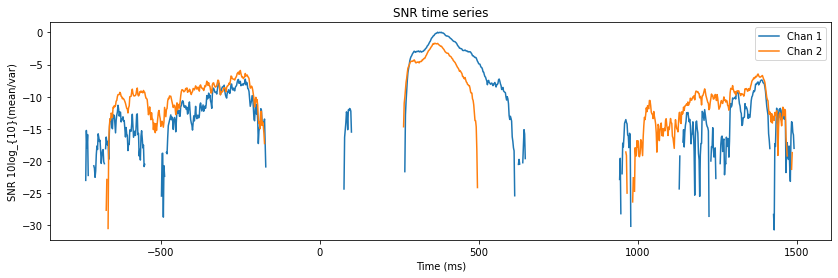

In [2]:

##  try in a voltage time series

# import data
matdat = sio.loadmat('SNRdata.mat')
timevec = np.squeeze( matdat['timevec'] )
eegdata = matdat['eegdata']
print(eegdata.shape) # channels nb points repetition

plt.figure(figsize=(14,8))
# plot mean and std data time series
plt.subplot(211)
plt.plot(timevec,np.mean(eegdata,2).T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage ($\mu$V)')
plt.legend(['Chan 1','Chan 2'])
plt.title('Average time series')


plt.subplot(212)
plt.plot(timevec,np.std(eegdata,2).T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (std.)')
plt.legend(['Chan 1','Chan 2'])
plt.title('Standard deviation time series')

plt.show()




## compute SNR
snr = np.mean(eegdata,2) / np.std(eegdata,2)

plt.figure(figsize=(14,4))
# plot
plt.plot(timevec,10*np.log10(snr).T)
#plt.plot(timevec,snr.T)
plt.xlabel('Time (ms)')
plt.ylabel('SNR 10log_{10}(mean/var)')
plt.legend(['Chan 1','Chan 2'])
plt.title('SNR time series')
plt.show()

The data above is 2 channels of a brain response to a stimulus.

The stimulus occures at time 0

There is 500 exp repetition, so you average those to get a single time point value.

For this data, SNR calcutation is not an appropriate measure because of the negatives results that lead to Nan numbers (or complex numbers) 

In [3]:
## alternative: SNR at a point
# Calculate SNR at one single point with a baseline noise. Here we select the point where the peak is

# pick time point
timepoint = 375
basetime  = [-500, 0]

# convert baseline time window to indices


# average over repetitions
erp = np.mean(eegdata,2)
bidx1 = np.argmin((timevec-basetime[0])**2) # find the index of timepoint -500
bidx2 = np.argmin((timevec-basetime[1])**2)


# SNR components
snr_num = erp[:,np.argmin((timevec-timepoint)**2)] # signal at time point 375
print(snr_num)
snr_den = np.std( erp[:,range(bidx1,bidx2)] ,1) # std of the baseline before 0. This is before stimulus 



# display SNR in the command window
print('SNR at %d ms in channel 1 = %g' %(timepoint,snr_num[0]/snr_den[0]) )
print('SNR at %d ms in channel 2 = %g' %(timepoint,snr_num[1]/snr_den[1]) )


[12.574579  9.660901]
SNR at 375 ms in channel 1 = 17.9399
SNR at 375 ms in channel 2 = 9.25177


# Code Challenge

Run the 2 cells above first

Text(0.5, 1.0, 'Erp spectrum')

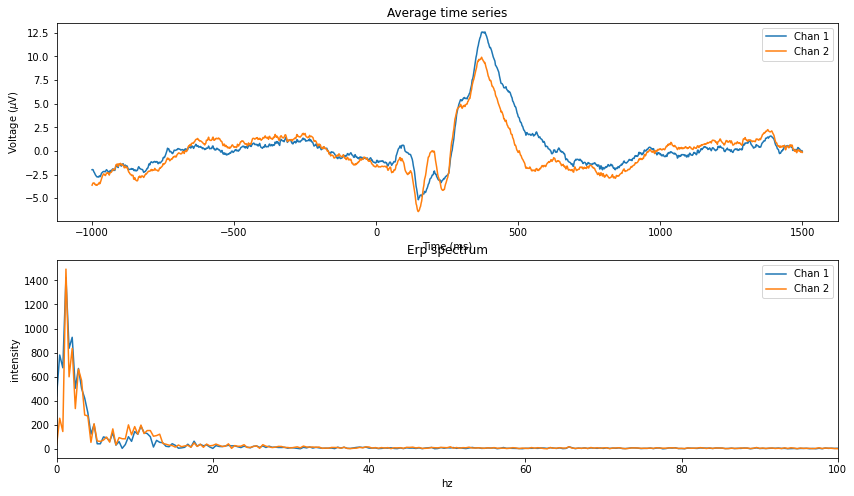

In [14]:
samprate = 1/(np.unique(np.diff(timevec))/1000) # convert from ms to sec
erp = np.mean(eegdata,2)
plt.figure(figsize=(14,8))
# plot mean and std data time series
plt.subplot(211)
plt.plot(timevec,erp.T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage ($\mu$V)')
plt.legend(['Chan 1','Chan 2'])
plt.title('Average time series')

hz   = np.linspace(0,samprate,len(timevec))
erpspec = np.abs(scipy.fftpack.fft(erp))
plt.subplot(212)
plt.plot(hz,erpspec.T)
plt.xlim([0,100])
plt.xlabel('hz')
plt.ylabel('intensity')
plt.legend(['Chan 1','Chan 2'])
plt.title('Erp spectrum')

300


Text(0.5, 1.0, 'Erp spectrum')

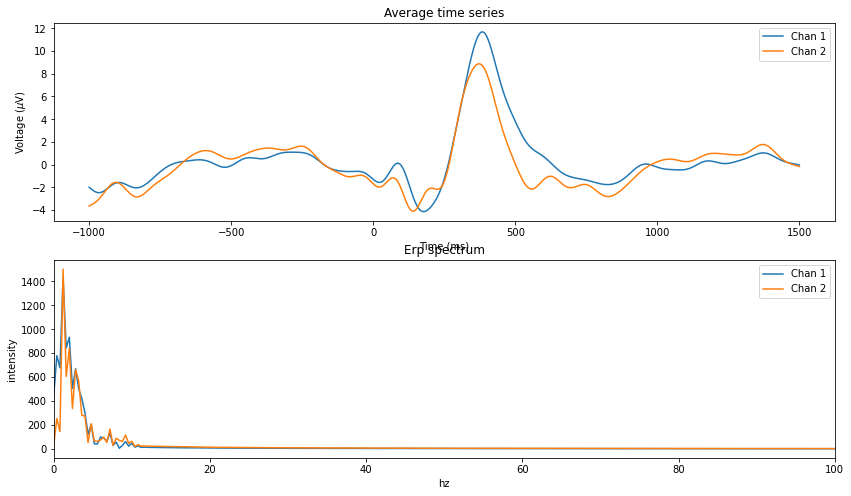

In [26]:
erp = np.mean(eegdata,2)
upper_bnd = 10# Hz
samprate = 1/(np.unique(np.diff(timevec))/1000) # convert from ms to sec
forder = int(1*samprate/upper_bnd)+1
forder = 300
print(forder)
filtkern = signal.firwin(forder,upper_bnd, fs=samprate, pass_zero=True)
erp = signal.filtfilt(filtkern,1,erp)

plt.figure(figsize=(14,8))
# plot mean and std data time series
plt.subplot(211)
plt.plot(timevec,erp.T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage ($\mu$V)')
plt.legend(['Chan 1','Chan 2'])
plt.title('Average time series')

hz   = np.linspace(0,samprate,len(timevec))
erpspec = np.abs(scipy.fftpack.fft(erp))
plt.subplot(212)
plt.plot(hz,erpspec.T)
plt.xlim([0,100])
plt.xlabel('hz')
plt.ylabel('intensity')
plt.legend(['Chan 1','Chan 2'])
plt.title('Erp spectrum')

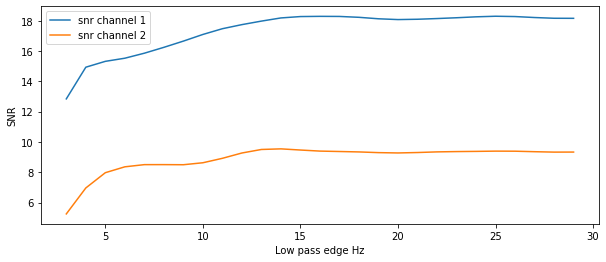

In [27]:
## alternative: SNR at a point
# Calculate SNR at one single point with a baseline noise. Here we select the point where the peak is

# pick time point
timepoint = 375
basetime  = [-500, 0]

# convert baseline time window to indices
hz_range = range(3,30)
channel1_snr = []
channel2_snr = []

for upper_bnd in range(3,30):
    # average over repetitions
    erp = np.mean(eegdata,2)
    
    # low pass filter
    samprate = 1/(np.unique(np.diff(timevec))/1000) # convert from ms to sec
    forder = int(1*samprate/upper_bnd)+1
    forder = 300
    filtkern = signal.firwin(forder,upper_bnd, fs=samprate, pass_zero=True)
    erp = signal.filtfilt(filtkern,1,erp)

    bidx1 = np.argmin((timevec-basetime[0])**2) # find the index of timepoint -500
    bidx2 = np.argmin((timevec-basetime[1])**2)

    # SNR components
    snr_num = erp[:,np.argmin((timevec-timepoint)**2)] # signal at time point 375
    snr_den = np.std( erp[:,range(bidx1,bidx2)] ,1) # std of the baseline before 0. This is before stimulus 

    channel1_snr.append(snr_num[0]/snr_den[0])
    channel2_snr.append(snr_num[1]/snr_den[1])


plt.figure(figsize=(10,4))
plt.plot(hz_range, channel1_snr, label="snr channel 1")
plt.plot(hz_range, channel2_snr, label="snr channel 2")
plt.xlabel('Low pass edge Hz')
plt.ylabel('SNR')
plt.legend()
plt.show()


---
# VIDEO: Coefficient of variation
---

cv = std / mean

It looks like the inverse of SNR

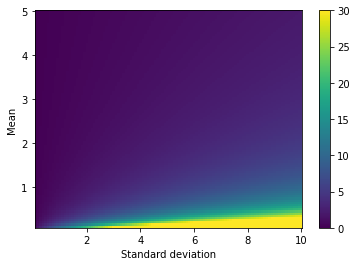

In [9]:
# number of data points
nmeans = 100
nstds  = 110

# ranges of means (den.) and standard deviations (num.)
means = np.linspace(0.1, 5, nmeans)
stds  = np.linspace(0.1, 10, nstds)


# initialize matrix
cv = np.zeros((nmeans,nstds))

# loop over all values and populate matrix
for mi in range(0,nmeans):
    for si in range(0,nstds):
        
        # coefficient of variation
        cv[mi,si] = stds[si] / means[mi]
        


# show in an image
plt.pcolormesh(stds,means,cv,vmin=0,vmax=30)
plt.ylabel('Mean')
plt.xlabel('Standard deviation')
plt.colorbar()
plt.show()


---
# VIDEO: Entropy
---

In signal processing we mean Shannon Entropy:

More entropy means more variability. Expl if I have an array of ( 1 1 1 1 1 1 ) entropy is 0, if ( 1 1 2 2) entropy is 1

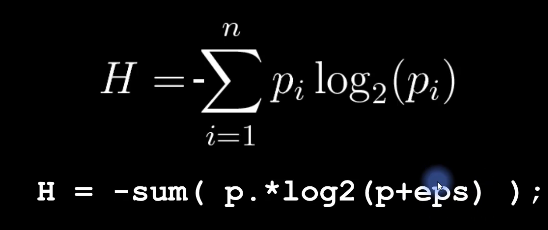


pi here is probablibity of i. And we add epsilon to not have a log(0)

Think about a human can be in too states: in the kitchen or in his office , n=2 and pi is the probability to be in the kitchen or in the office.

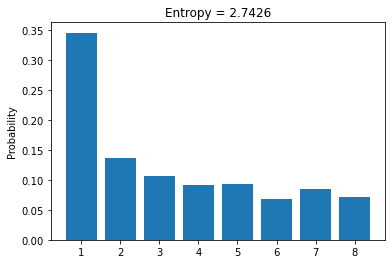

In [15]:
## "discrete" entropy
# Simple case

# generate data
N = 1000
numbers = np.ceil( 8*np.random.rand(N)**2 ) # only  nb in [1 2 3 4 5 6 7 8] so 8 states


# get counts and probabilities
u = np.unique(numbers)
probs = np.zeros(len(u))

for ui in range(0,len(u)):
    probs[ui] = np.sum(numbers==u[ui]) / N


# compute entropy
entropee = -np.sum( probs*np.log2(probs+np.finfo(float).eps) )


# plot
plt.bar(u,probs)
plt.title('Entropy = %g' %entropee)
plt.ylabel('Probability')
plt.show()

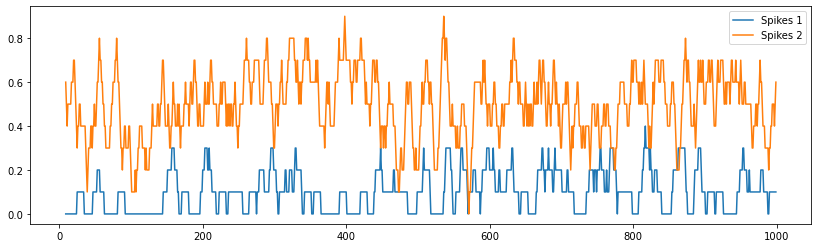

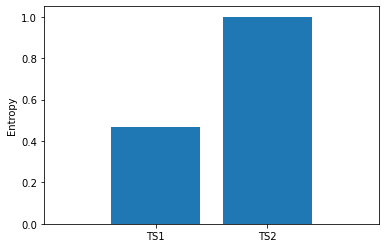

In [41]:
## same procedure for spike times
#creates spikets where numbers can be only 0 or 1

# generate spike times series
spikets1 = np.zeros(N)
spikets2 = np.zeros(N)

# nonrandom
spikets1[ np.random.rand(N)>.9 ] = 1

# equal probability
spikets2[ np.random.rand(N)>.5 ] = 1

# probabilities
# (note: this was incorrect in the video; the entropy of the entire time
# series requires the probability of each event type. And the theoretical
# entropy of a random binary sequence is 1.)
probs1 = ( np.sum(spikets1==0)/N, np.sum(spikets1==1)/N )
probs2 = ( np.sum(spikets2==0)/N, np.sum(spikets2==1)/N )

# compute entropy
entropee1 = -np.sum( probs1*np.log2(probs1+np.finfo(float).eps) )
entropee2 = -np.sum( probs2*np.log2(probs2+np.finfo(float).eps) )



# convert data to pandas for smoothing
spikets1 = Series(spikets1).rolling(window=10)
spikets2 = Series(spikets2).rolling(window=10)

plt.figure(figsize=(14,4))
plt.plot(np.arange(0,N),spikets1.mean(),label='Spikes 1')
plt.plot(np.arange(0,N),spikets2.mean(),label='Spikes 2')
plt.legend()
plt.show()


plt.bar([1,2],[ entropee1, entropee2 ])
plt.xlim([0, 3])
plt.xticks([1,2],('TS1','TS2'))
plt.ylabel('Entropy')
plt.show()


The entropy of equally distributed binary outcome is 1

(16, 1527, 200)


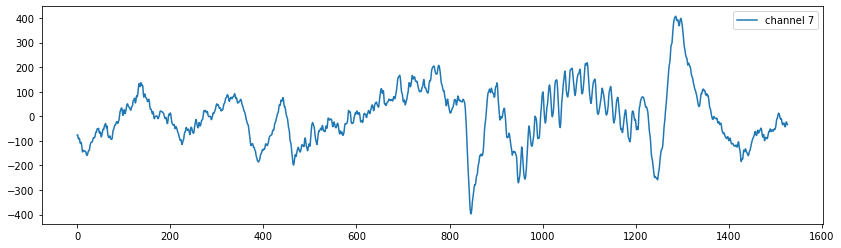

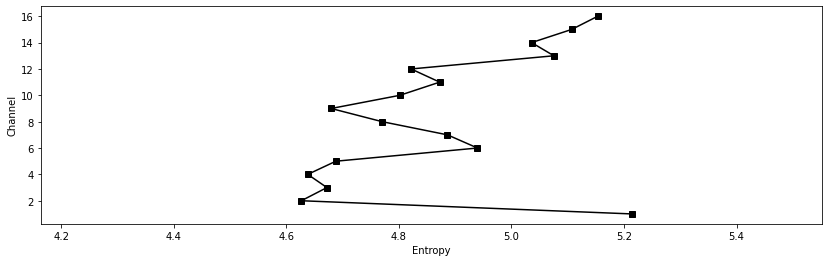

In [46]:
## extra step for analog time series


# load data time series
matdat = sio.loadmat('v1_laminar.mat')
csd = matdat['csd']

# sizes of the dimensions (chan , time , repetitions)
csdsize = np.shape(csd)
print(csd.shape)

# compute event-related potential (averaging)
erp = np.mean(csd,2)


# crucial parameter -- number of bins! to discretize
nbins = 50


# initialize entropy matrix
entro = np.zeros(csdsize[0])

# compute entropy for each channel
for chani in range(0,csdsize[0]):
    
    # find boundaries
    edges = np.linspace(np.min(erp[chani,:]),np.max(erp[chani,:]),nbins) # what are the bins
    
    # bin the data
    nPerBin,bins = np.histogram(erp[chani,:],edges)
    #nPerBin,bins = np.histogram(erp[chani,:],nbins) # gives equal result doing the bin itself
    
    # convert to probability
    probs = nPerBin / np.sum(nPerBin)
    
    # compute entropy
    entro[chani] = -np.sum( probs*np.log2(probs+np.finfo(float).eps) )
    
plt.figure(figsize=(14,4))
plt.plot(np.arange(0,len(erp[7])),erp[7], label="channel 7")
plt.legend()
plt.show()
    
plt.figure(figsize=(14,4))
# plot
plt.plot(entro,np.arange(1,17),'ks-')
plt.xlim([np.min(entro)*.9, np.min(entro)*1.2])
plt.xlabel('Entropy')
plt.ylabel('Channel')
plt.show()

In [37]:
edges

array([-76.53212738, -72.73216575, -68.93220411, -65.13224248,
       -61.33228084, -57.53231921, -53.73235757, -49.93239594,
       -46.1324343 , -42.33247266, -38.53251103, -34.73254939,
       -30.93258776, -27.13262612, -23.33266449, -19.53270285,
       -15.73274122, -11.93277958,  -8.13281795,  -4.33285631,
        -0.53289468,   3.26706696,   7.06702859,  10.86699023,
        14.66695186,  18.4669135 ,  22.26687513,  26.06683677,
        29.8667984 ,  33.66676004,  37.46672167,  41.26668331,
        45.06664494,  48.86660658,  52.66656821,  56.46652985,
        60.26649148,  64.06645312,  67.86641475,  71.66637639,
        75.46633802,  79.26629966,  83.06626129,  86.86622293,
        90.66618456,  94.4661462 ,  98.26610783, 102.06606947,
       105.8660311 , 109.66599274])

In a real time series there is infinite values a point can take, it is not discreete.
So you nee to discretize it with bins.

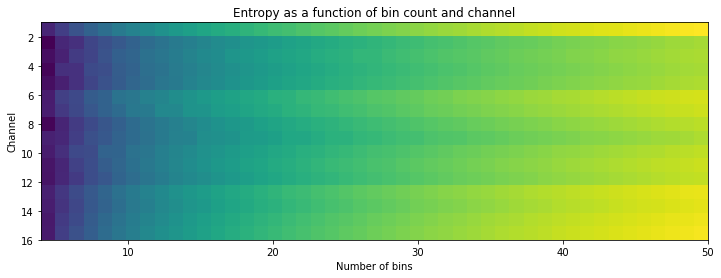

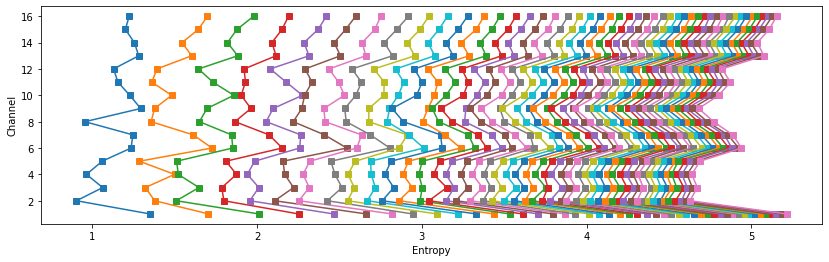

In [44]:
## loop over bin count
# What is I change the nb of bins

# variable number of bins!
nbins = np.arange(4,51)

# initialize
entro = np.zeros((np.shape(erp)[0],len(nbins)))

for bini in range(len(nbins)):
    
    # compute entropy as above
    for chani in range(np.shape(erp)[0]):
        edges = np.linspace(np.min(erp[chani,:]),np.max(erp[chani,:]),nbins[bini])
        nPerBin,bins = np.histogram(erp[chani,:],edges)
        probs = nPerBin / np.sum(nPerBin)
        entro[chani,bini] = -np.sum( probs*np.log2(probs+np.finfo(float).eps) )


plt.figure(figsize=(14,4))
plt.imshow(entro, extent=[4,50,16,1])
plt.xlabel('Number of bins')
plt.ylabel('Channel')
plt.title('Entropy as a function of bin count and channel')
plt.show()

plt.figure(figsize=(14,4))
plt.plot(entro,np.arange(1,17),'s-')
plt.xlabel('Entropy')
plt.ylabel('Channel')
plt.show()

Entropy is increasing with the nb of bins